# 09-03 - Perceptron Classification

*June 26 2024*  

We introduce the perceptron, which is the fundamental building block of (deep) neural networks. We consider a perceptron classifier with a logistic activation function, which is the one-dimensional version of the so-called [softmax function](https://en.wikipedia.org/wiki/Softmax_function) that is often used in neural networks. We implement a simple gradient-based learning algorithm and implement the model in a style that mimics the implementation of deep neural networks in `pytorch`.

In [1]:
import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd
from scipy.special import expit
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

To test and illustrate our model, we first generate the same (linearly separable) example data as in the first notebook.

In [2]:
def response(x, boundary=0.2, prob_1=1):
    if x > boundary:
        if np.random.random_sample() < prob_1:
            return 1
        else:
            return 0
    else:
        if np.random.random_sample() < 1-prob_1:
            return 1
        else:
            return 0

<AxesSubplot:xlabel='x', ylabel='y_class'>

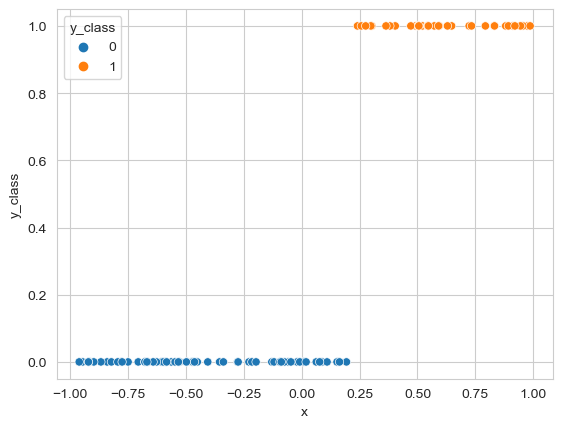

In [3]:
x = 2*scipy.stats.uniform.rvs(size=100)-1
y = np.array([ response(x[i]) for i in range(len(x)) ])

data = pd.DataFrame({'x': x, 'y_class': y})

sns.scatterplot(x='x', y="y_class", data=data, hue='y_class')

Referring to the lecture, we can view a logistic regression as special case of a perceptron classifier, where the features represent a (possibly vector-valued) input, and the neuron generates a binary output. This output is computed based on the linear combination of features (with an additional bias/intercept term that determines the "threshold potential"). The "activation function", which we can choose as logistic function, maps the value of the linear function to values in [0,1] that can be interpreted as probability of the positive class.

We can implement this simple model as follows. Here we use the convention of a `pytorch` model, which has a `forward` function that takes the input and generates an output based on the current parameters. This approach will later help us to understand how to use (graph) neural networks based on `pytorch` and `torch-geometric`.

In [7]:
class Perceptron:

    def __init__(self, bias, beta):
        self.bias = bias
        self.beta = beta

    def forward(self, x):
        y = self.bias + np.dot(self.beta, x)
        return expit(y)

Again following the style of optimization algorithms included in `pytorch`, we implement a class `GradientDescentOptimizer`, which can be initialized with different hyperparameters and performs updates of the model parameters.

In [8]:
class GradientDescentOptimizer:

    def __init__(self, model, lr):
        self.lr = lr
        self.model = model

    def step(self, y, y_true, feature):
        self.model.beta = self.model.beta - self.lr * (y-y_true) * y * (1-y) * feature
        self.model.bias = self.model.bias - self.lr * (y-y_true) * y * (1-y)

We now initialize our Perceptron model as well as our optimizer class. Following the nomenclature of neural networks, the optimization is run for a number of so-called **epochs**. In each epoch we use all of our data points to learn the parameters of our perceptron model, i.e. by using multiple epochs we use all data points in our training set more than once. 

Each epoch can of multiple **iterations**, where each iteration uses a **batch** of data points to update the model parameters. Below, we use a single data point per iteration, which would correspond to a batch size of one.

Using this approach, we can now learn the two parameters of our perceptron model based on our training data. We finally output the parameters, which correspond to the intercept and slope of our logistic regression model. We also plot the evolution of our model error in each epoch, showing that it converges to zero (at least for our simple example of data points that can easily be separated using the right parameters).

-2.9961758068465634 13.778657833953405


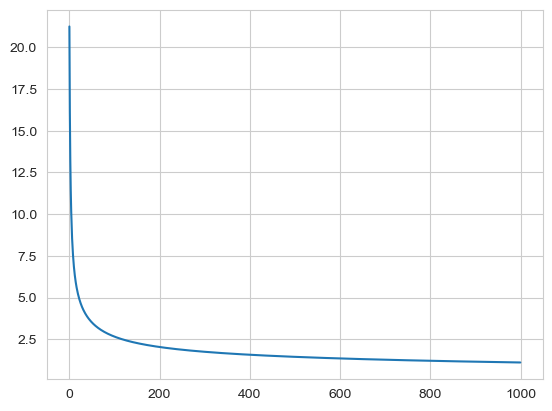

In [9]:
error = np.inf
tol = 0.05
learning_rate = 0.1
epochs = 1000

model = Perceptron(0,0)
optimizer = GradientDescentOptimizer(model, lr=learning_rate)

errors = []
num_epochs = 0

# in each epoch we use all of our training data to update the model parameters once
for i in range(epochs):
    error = 0

    # in each iteration we use a single data point, i.e. here we have a batch size of one
    # and the number of iterations is equal to the number of batches
    for iteration, row in data.iterrows():

        # compute output for feature x
        y = model.forward(row['x'])

        # compute loss
        loss = (row['y_class']-y)**2
        error += np.abs(loss)

        # in each iteration, we update model parameters based on gradient descent
        optimizer.step(y, row['y_class'], row['x'])

    errors.append(error)
    num_epochs += 1
    if error <= tol:
        break

plt.plot(range(num_epochs), errors)

print(model.bias, model.beta)

Let us now plot the decisions of our model. Since the output are class probabilities, we need to dichotomize the output based on a threshold of 0.5. This corresponds to a step activation function.

           x  y_class  prediction
0  -0.405341        0           0
1  -0.128811        0           0
2   0.006452        0           0
3  -0.705510        0           0
4  -0.749334        0           0
..       ...      ...         ...
95  0.920740        1           1
96 -0.087891        0           0
97 -0.920595        0           0
98 -0.532271        0           0
99 -0.960391        0           0

[100 rows x 3 columns]


<AxesSubplot:xlabel='x', ylabel='y_class'>

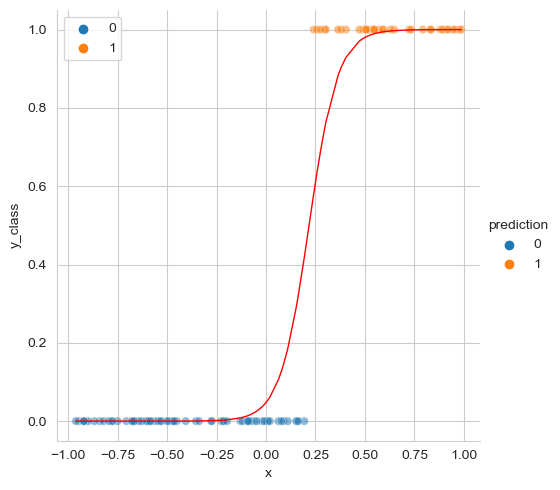

In [10]:
def decision(output):
    if output>0.5:
        return 1
    else:
        return 0

xx = data['x']
data['prediction'] = [ decision(model.forward(x)) for x in xx]
print(data)
sns.relplot(x='x', y="y_class", hue='prediction', data=data, alpha=0.5)
sns.lineplot(x=data['x'], y=expit(model.bias + x * model.beta).ravel(), color='red', linewidth=1)

This concludes our implementation of the Perceptron classifier. In the next notebook, we will repeat this implementation based on the popular machine learning package `pytorch`.